## Setup

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import pandas as pd
import time

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import (
    EffectiveAreaTable2D,
    EnergyDispersion2D,
    EnergyDependentMultiGaussPSF,
    Background3D,
)
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum import models
from gammapy.image.models import SkyPointSource
from gammapy.cube.models import SkyModel
from gammapy.cube import MapFit, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf

from gammapy.astro.darkmatter import PrimaryFlux
from gammapy.utils.fitting import Parameter, Parameters

## Load IRFs

In [3]:
def get_irfs():
    """Load CTA IRFs"""
    filename = "$CTADATA/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    psf = EnergyDependentMultiGaussPSF.read(
        filename, hdu="POINT SPREAD FUNCTION"
    )
    aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
    edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
    bkg = Background3D.read(filename, hdu="BACKGROUND")
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)
irfs = get_irfs()

## Derive ancillary IRF maps 

**Define map geometry**

In [4]:
GLON = 96.34 * u.Unit("deg")
GLAT = -60.19 * u.Unit("deg")
src_pos = SkyCoord(GLON, GLAT, frame="galactic")
emin = 0.03 * u.Unit("GeV")
emax = 100 * u.Unit("GeV")
lg_emin = np.log10(emin.value)
lg_emax = np.log10(emax.value)
NBINS = 30

In [5]:
axis = MapAxis.from_edges(
    np.logspace(lg_emin, lg_emax, NBINS),
    unit="TeV",
    name="energy",
    interp="log",
)
geom = WcsGeom.create(
    skydir=src_pos, binsz=0.02, width=(2, 2), coordsys="GAL", axes=[axis]
)

**Declare observation values**

In [6]:
pointing = src_pos
livetime = 50 * u.hour
offset = 1 * u.deg

**Build maps**

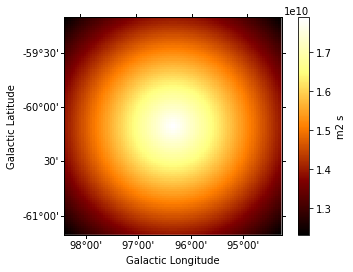

In [7]:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs["aeff"], geom=geom
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

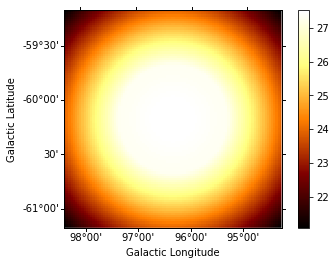

In [8]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
)
background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

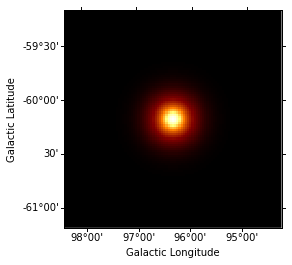

In [9]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=1 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

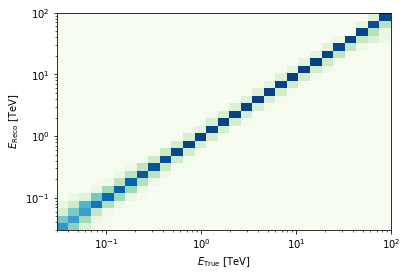

In [10]:
edisp = irfs["edisp"].to_energy_dispersion(
    offset=offset, e_reco=axis.edges * axis.unit, e_true=axis.edges * axis.unit
)
edisp.plot_matrix();

## Build model

**Declare constants and parameters for our DM model**

In [11]:
PI8 = 8 * np.pi
CROSS_SECTION = 1e-28 * u.Unit("cm3 s-1")
Jfac = 3.41e19 * u.Unit("GeV2 cm-5") # <--- point source / may be also a 2D map
mDM = 5000*u.Unit("GeV")
channel_list = ["b"] 

**Fetch Primary Flux**

https://docs.gammapy.org/0.10/notebooks/astro_dark_matter.html

In [12]:
dNdE = PrimaryFlux(mDM, channel=channel_list[0])

**Define Spectral User Model**

https://docs.gammapy.org/0.10/notebooks/spectrum_models.html#User-defined-model

In [13]:
class UserModel(models.SpectralModel):
    def __init__(self, Norm, mass, channel_index, Jfac):
        self.parameters = Parameters(
            [
                Parameter("Norm", Norm, min=0),
                Parameter("mass", mass, frozen=True),
                Parameter("channel_index", channel_index, frozen=True),
                Parameter("Jfac", Jfac, frozen=True),
            ]
        )
        dNdE.mDM = mass
        dNdE.channel = channel_list[channel_index]
        
    @staticmethod
    def evaluate(energy, Norm, mass, channel_index, Jfac):
        flux = (
            Norm
            * Jfac
            * CROSS_SECTION
            * dNdE.table_model.evaluate(energy=energy, norm=1)
            / mass
            / mass
            / PI8
        )
        return flux

**Define 3D Sky Model**

In [14]:
spectral_model = UserModel(
    Norm=1, mass=mDM, channel_index=0, Jfac=Jfac
)
spatial_model = SkyPointSource(lat_0=GLAT, lon_0=GLON)  # <--- because JFactor is a number
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)

## Evaluate and display our 3D model simulation

In [15]:
evaluator = MapEvaluator(
    model=sky_model,
    exposure=exposure,
    background=background,
    psf=psf_kernel,
    edisp=edisp,
)

In [16]:
npred = evaluator.compute_npred()
npred_map = WcsNDMap(geom, npred)

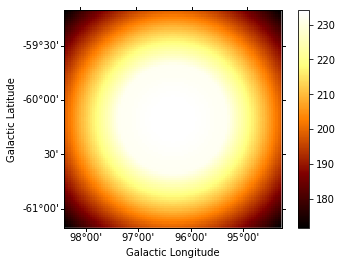

In [17]:
npred_map.sum_over_axes().plot(add_cbar=True);

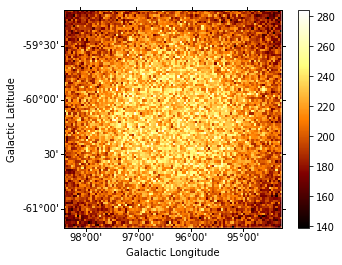

In [18]:
rng = np.random.RandomState(seed=int(time.time()))
counts = rng.poisson(npred)
counts_map = WcsNDMap(geom, counts)
counts_map.sum_over_axes().plot(add_cbar=True);

## Fit model loop

** Likelihood Ratio Function **

In [19]:
SIGMA = 2 # 95% CI
def ts_diff(x):
    result.model.parameters["Norm"].value = x
    stat = fit.total_stat(result.model.parameters)
    return (stat - stat_best_fit) - SIGMA**2

**Fit for different mDM and channels**

In [20]:
%%time
massval_list = [70, 200, 500, 5000, 10000, 50000, 100000]
channel_list = ["b"] 
NumberOfRuns = 9

# data structure
columns = ["run", "mass", "sigma_v"]
df = pd.DataFrame(columns=columns)

# loop
for run in range(NumberOfRuns):

    rng = np.random.RandomState(seed=run+int(time.time()))
    counts = rng.poisson(npred)
    counts_map = WcsNDMap(geom, counts)
    
    print('#-----------------------------------------')
    print("RUN", run+1)
    for ch in range(len(channel_list)):
        for mass in massval_list:
            print("Mass", mass)
            
            # ------- TUNE IN MODEL IN MASS/CHANNEL RANGE
            spectral_model = UserModel(
                            Norm = 1,
                            mass = mass * u.GeV,
                            channel_index = ch,
                            Jfac = Jfac
                            )
            model3D = SkyModel(
                            spatial_model=spatial_model, spectral_model=spectral_model
                            )
            
            # ------- FIT TO FIXED MODEL
            model3D.parameters['lat_0'].frozen=True
            model3D.parameters['lon_0'].frozen=True
            fit = MapFit(
                model=model3D,
                counts=counts_map,
                exposure=exposure,
                background=background,
                psf=psf_kernel,
                edisp=edisp,
            )

            result = fit.run()
            pars = result.model.parameters
            stat_best_fit = fit.total_stat(pars)  # <- maximum likelihood from fit
            Norm_best = pars["Norm"].value
            
            scale = brentq(ts_diff, Norm_best, 1e18, maxiter=100, rtol=1e-3)
            fSigma_v = scale * CROSS_SECTION.value

            df = df.append(
                {"run": run, "mass": mass, "sigma_v": fSigma_v},
                ignore_index=True,
            )
            print("Scale", scale)

#-----------------------------------------
RUN 1
Mass 70
Scale 157918.1142843612
Mass 200
Scale 28876.868736115768
Mass 500
Scale 16554.77589520264
Mass 5000
Scale 18068.00325278591
Mass 10000
Scale 26763.15853783506
Mass 50000
Scale 52724.99164073584
Mass 100000
Scale 82310.74257139061
#-----------------------------------------
RUN 2
Mass 70
Scale 62678.104085324456
Mass 200
Scale 12534.944138519148
Mass 500
Scale 6899.786674842956
Mass 5000
Scale 8532.014089942712
Mass 10000
Scale 11509.769007925512
Mass 50000
Scale 34372.47464723769
Mass 100000
Scale 58968.795236306345
#-----------------------------------------
RUN 3
Mass 70
Scale 124452.42808325385
Mass 200
Scale 24453.161629872608
Mass 500
Scale 12748.697900003885
Mass 5000
Scale 12614.5475536664
Mass 10000
Scale 14623.368226693998
Mass 50000
Scale 21613.705398471466
Mass 100000
Scale 33773.2729630299
#-----------------------------------------
RUN 4
Mass 70
Scale 102451.05553110426
Mass 200
Scale 24639.82482137386
Mass 500
Scale 1

## Plot obtained results

In [21]:
df[["run"]] = df[["run"]].astype(int)
df[["mass"]] = df[["mass"]].astype(int)

stats = df.groupby(["mass"]).mean()
stats_std = df.groupby(["mass"]).std()
stats.drop(["run"], axis=1, inplace=True)
stats_std.drop(["run"], axis=1, inplace=True)
stats_std.columns = ["std_sigma_v"]

stats = pd.merge(stats, stats_std, left_index=True, right_index=True)
stats

,sigma_v,std_sigma_v
mass,,
70,1.227960e-23,4.201361e-24
200,2.496729e-24,6.683469e-25
500,1.253084e-24,3.586787e-25
5000,1.477987e-24,6.588003e-25
10000,1.905908e-24,7.007741e-25
50000,3.837820e-24,1.270757e-24
100000,6.329425e-24,2.415951e-24


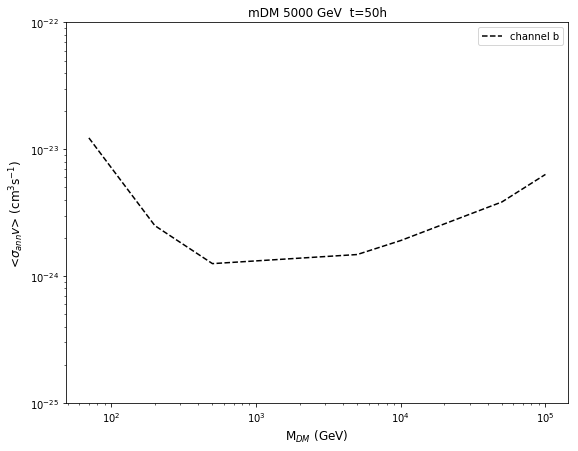

In [33]:
fig, ax1 = plt.subplots(1, figsize=(9, 7))

ax1.loglog(
    stats.index.values,
    stats["sigma_v"],
    color="k",
    ls="--",
    label='channel b'
)

ax1.set_xlabel("M$_{DM}$ (GeV)", fontsize=12)
ax1.set_ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
ax1.set_ylim(1e-25, 1e-22)
ax1.set_title("mDM 5000 GeV  t=50h")
ax1.legend()